# **Project BTS**
### Author: Justin Yoon
### Digital Humanities 100 Summer 2021
### Instructor: Dr. Adam Anderson

In [ ]:
pip install vaderSentiment

     |████████████████████████████████| 133kB 26.5MB/s 


In [ ]:
pip install markdown_strings

In [ ]:
import numpy as np
import pandas as pd
import io
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import random
from google.colab import drive
from IPython.display import YouTubeVideo
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

#**The Data**

In [ ]:
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
lyrics = pd.read_csv (r'/content/gdrive/MyDrive/Justin_Yoon/Notebook/lyrics-v1.0.csv')
spotify = pd.read_csv (r'/content/gdrive/MyDrive/Justin_Yoon/Notebook/tracks.csv')

In [ ]:
#Add more data here; Search engine time series, Wikipedia scrape

The dataframe `lyrics` contains 226 observations of BTS tracks and includes `album_title`, `track_title`, `lang` (the language of the song) and, most importantly, `lyrics` as features. This dataframe is provided by Kaggle user **kaili** who scraped this data from https://genius.com/  under a **CC0: Public Domain License**.
<br/><br/>

The dataframe `spotify` is also a Kaggle dataset by user **Yamac Eren Ay** who, by using the Spotify API, has scraped data from about around 600,000 tracks published on Spotify under **Community Data License Agreement – Sharing, Version 1.0**. 
<br/><br/>

*Note that the "full" dataset has over 15 million tracks and includes data about specific artists, but is over 3GB in storage.* 
<br/><br/>

This dataset provides information on easily gathered features such as `popularity` and `duration_ms`, but also Spotify measures their own audio features such as `danceability`, `energy`, `key`, `loudness`, `mode` and much more. 
The full description of these features can be found at https://developer.spotify.com/documentation/web-api/reference/#category-tracks under AudioFeaturesObject.




In [ ]:
def data_stats(df):
  ##Input: A df derived from lyrics
  ##Output: Some statistics about the df
  tracks = df.shape[0]
  albums = len(df["album_title"].unique())
  print("There are "+str(tracks)+ " songs spread across "+str(albums)+" albums in this dataframe.")
data_stats(lyrics)

There are 226 songs spread across 18 albums in this dataframe.


#**Data Cleaning**

Let's take a closer look at the data.

In [ ]:
lyrics[lyrics["track_title"]=="Dynamite"] #Finds all tracks with "Dynamite" in the title

,id,album_title,eng_album_title,album_rd,album_seq,track_title,kor_track_title,eng_track_title,lyrics,hidden_track,remix,featured,performed_by,repackaged,lang,has_full_ver
206,206,Dynamite (DayTime Version),Dynamite (DayTime Version),28/8/20,1,Dynamite,NaN,Dynamite,"Cause I, I, I'm in the stars tonight\nSo watch...",False,False,NaN,BTS,False,ENG,False
212,212,Dynamite (NightTime Version),Dynamite (NightTime Version),18/9/20,1,Dynamite,NaN,Dynamite,"Cause I, I, I'm in the stars tonight\nSo watch...",False,False,NaN,BTS,True,ENG,False
225,225,BE,BE,20/11/20,8,Dynamite,NaN,Dynamite,"Cause I, I, I'm in the stars tonight\nSo watch...",False,False,NaN,BTS,True,ENG,False


As you can see there is some redundant, data (from single releases, album rereleases, etc) and we do not want redundant data to bias our results. We will also filter out "intro" and "outro" songs as we deem them to be of little value lyrically.

In [ ]:
copy = lyrics.copy()

We first copy the data (so that we can always go back to the full data if we omit too many songs).

In [ ]:
copy = copy[copy["eng_track_title"].str.contains("Intro")!=True] #removes intros
copy = copy[copy["eng_track_title"].str.contains("Outro")!=True] #removes ontros
copy = copy[copy["eng_track_title"].str.contains("Skit")!=True] #removes skits
copy = copy.drop_duplicates(subset=["track_title"]) #removes duplicate tracks
copy = copy[pd.notna(copy["lang"])] #removes non-English and non-Korean tracks (instrumental tracks)
copy = copy[copy["performed_by"]== "BTS"] #removes tracks not performed by all of BTS (removes solo/duo tracks)
copy = copy[copy["remix"]!=True] #removes remixes (which offer the same lyrics)
clean_lyrics = copy

In [ ]:
clean_lyrics[clean_lyrics["track_title"]=="Dynamite"] #We check that Dynamite is listed only once.

,id,album_title,eng_album_title,album_rd,album_seq,track_title,kor_track_title,eng_track_title,lyrics,hidden_track,remix,featured,performed_by,repackaged,lang,has_full_ver
206,206,Dynamite (DayTime Version),Dynamite (DayTime Version),28/8/20,1,Dynamite,NaN,Dynamite,"Cause I, I, I'm in the stars tonight\nSo watch...",False,False,NaN,BTS,False,ENG,False


In [ ]:
data_stats(clean_lyrics)

There are 89 songs spread across 17 albums in this dataframe.


Through cleaning, we cut the size of dataset in half.

##**Merging**

In [ ]:
BTS_spotify = spotify[spotify["artists"].str.contains("BTS")] #Takes only BTS songs from spotify (spotify includes all artists from the US market)
BTS_spotify["pri"]= BTS_spotify["name"].str.replace(" ", "").str.replace(",", "").str.lower().str[0:15]
BTS_spotify = BTS_spotify.sort_values("popularity", ascending= False)
BTS_spotify = BTS_spotify.drop_duplicates(subset=["pri"]) #Deletes repeated tracks with lower popularity
BTS_spotify = BTS_spotify[BTS_spotify["name"].str.contains("Japan")!=True] #removes Japanese rereleases
BTS_spotify = BTS_spotify[BTS_spotify["name"].str.contains("Remix")!=True] #removes remixes

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


To better analyze our data, we need to merge them. But, we notice that the datasets have **no primary key** to merge on, so we use `track_title` (from `lyrics`) and `name` (from `spotify`).

In [ ]:
clean_lyrics.merge(BTS_spotify, how = "inner", left_on= "track_title", right_on= "name").shape

(5, 37)

But, it turns out `track_title` and `name` are not good primary keys to merge on! (The merge only resulted in 5 tracks.)

In [ ]:
clean_lyrics["pri"] = clean_lyrics["eng_track_title"].str.replace(" ", "").str.lower().str[0:15]
BTS_spotify["pri"]= BTS_spotify["name"].str.replace(" ", "").str.replace(",", "").str.lower().str[0:15]

Using trial and error (and through our understanding of BTS songs), we find that using the **first 15 letters of each track is good enough to use as a primary key** to link the datasets. We manually check for errors. This method preserves 93 merged observations.

In [ ]:
merged = clean_lyrics.merge(BTS_spotify, how = "inner", on="pri")
data_stats(merged)

There are 72 songs spread across 17 albums in this dataframe.


In [ ]:
len(merged["id_x"].unique())== merged.shape[0]  #checks that all values of clean_lyrics are unique

True

In [ ]:
len(merged["lyrics"].unique())== merged.shape[0] #checks that lyrics are also unique

True

Above is what our merged dataset looks like. **We started from 226 observations to 72 observations through cleaning and merging** and deem this to be a good candidate to do further data analysis.

In [ ]:
merged["clean"] = merged["lyrics"].str.lower().str.replace("\\n", " ", regex = True).str.replace("\([\w\s]*\)", "", regex = True) 
#cleans up the lyrics for text analysis

#**Data Quality Check**

As data scientists, we have to understand the methodology we are using to measure our subject. In this case, we have many cultural goods (BTS songs) that come pre-analyzed from Spotify. Especially in subjective contexts like these, we need to consistently check the quality and purity of our data in order to make sure that our results are sensible and reliable. Before moving on to the EDA, we want to dive into the data ourselves to truly see if that data is "faithful" to what it is trying to measure.

BTS's most **danceable** tracks?

In [ ]:
merged.sort_values("danceability", ascending= False).iloc[0:5]["name"]

19    Look Here
46        Go Go
53     Anpanman
4         We On
70    Telepathy
Name: name, dtype: object

Judge for yourself!

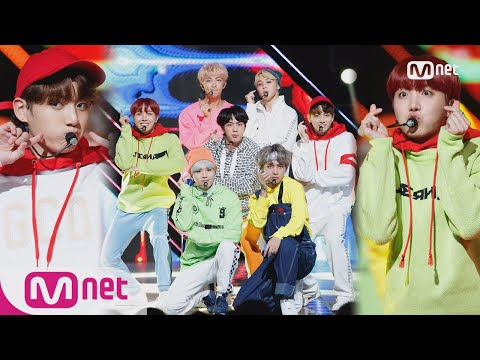

In [ ]:
YouTubeVideo("TEl6KgcfSA8")

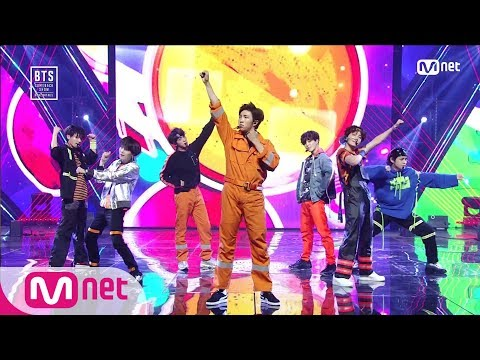

In [ ]:
YouTubeVideo("qkLMPihvKaQ")

BTS's highest **energy** tracks?

In [ ]:
merged.sort_values("energy", ascending= False).iloc[0:3]["name"]

15    War of Hormone
12              Jump
29           Ma City
Name: name, dtype: object

Judge for yourself!

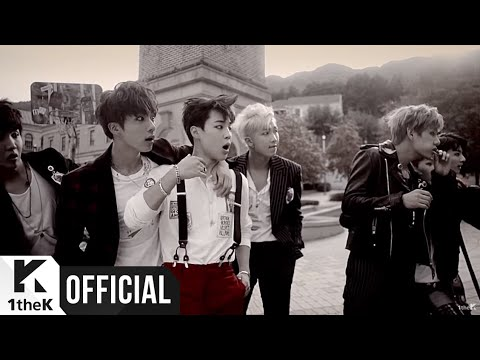

In [ ]:
YouTubeVideo("XQmpVHUi-0A")

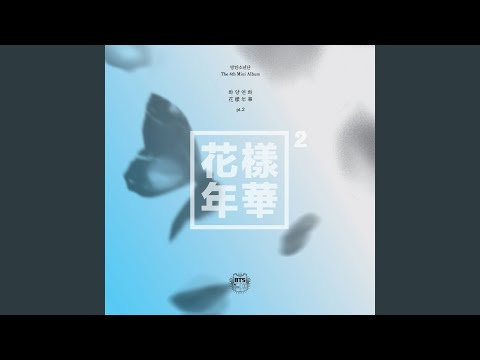

In [ ]:
YouTubeVideo("MlM1fbaHZTQ")

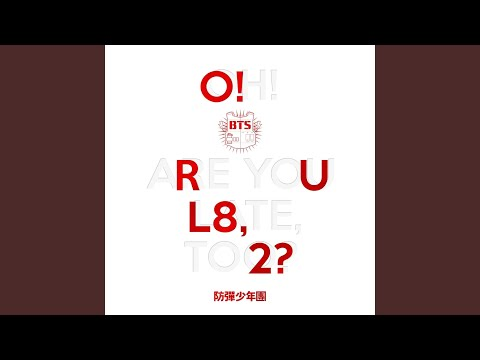

In [ ]:
YouTubeVideo("qPC5s_R6cfE")

Highest **Valence** Tracks (valence = positivity, happiness)

In [ ]:
merged.sort_values("valence", ascending= False).iloc[0:3]["name"]

25        Moving On
49         Paradise
52    Airplane pt.2
Name: name, dtype: object

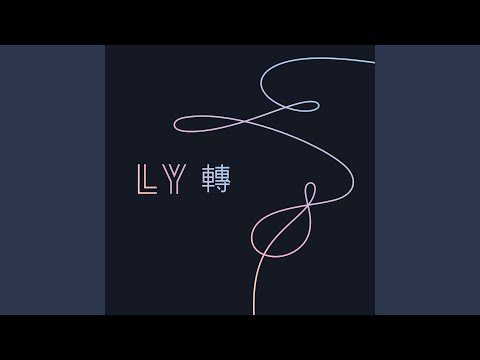

In [ ]:
YouTubeVideo("obH7iPDAn2Q")

Lowest Valence Tracks

In [ ]:
merged.sort_values("valence", ascending= True).iloc[0:5]["name"]

16                         Let Me Know
0     We are Bulletproof : the Eternal
1     We are Bulletproof : the Eternal
62                           Jamais Vu
60                       Make It Right
Name: name, dtype: object

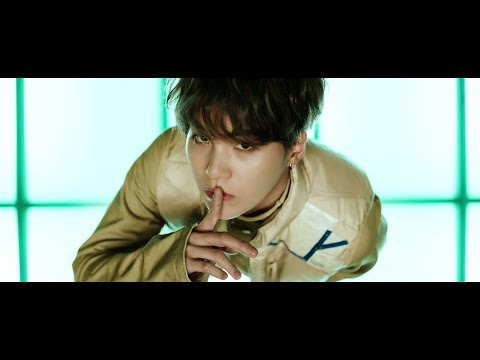

In [ ]:
YouTubeVideo("PV1gCvzpSy0")

Now, let's take a look at the lyrics themselves. <br/><br/>
We have to understand the BTS performs their songs in English AND Korean(meaning that certain songs are exclusively English, some exclusively Korean and many contain English and Korean in one song). Furthermore, BTS also happens to rerelease many of their songs in Japanese (though our dataset omits this). <br/><br/>
Translation of artistic works as such is notoriously hard and academics still debate on which version/method is the most "representative" of the original untranslated work. <br/><br/>

Furthermore, digital text analysis and NLP ([natural language processing](https://en.wikipedia.org/wiki/Natural_language_processing)) in multiple languages is also incredibly difficult for [multiple reasons](https://analyticsindiamag.com/how-nlp-can-tackle-the-challenge-of-multiple-languages/). One challenge is to find the Korean equivalent of VADER for language that's hard to tokenize. Another glaring challenge for us with VADER is that we have no way of confirming that the weights (sentiment scores) are "proportionate." <br/><br/>

e.g. In BTS's song [FAKE LOVE](https://www.youtube.com/watch?v=7C2z4GqqS5E&ab_channel=HYBELABELS), the word "love" in the lyrics must give the same sentiment as the word "[사랑](https://en.wiktionary.org/wiki/%EC%82%AC%EB%9E%91)" when both words are used multiple times throughout the song. This is not always guaranteed with different versions of VADER.<br/><br/>

To depart from these logistical and, potentially, unsolveable hurdles, the data that we import in the first place is translated into English by [Genius](https://genius.com/). We defend the use of 3rd party translated lyrics in our data analysis because a vast majority of BTS's fans are not fluent in **BOTH** Korean and English. This leads us to infer that fans are searching for the true meaning of the songs through the Internet with sites such as [Genius](https://genius.com/). <br/><br/>

But, we must also confirm that Genius's translations are indeed well-translated. To check of all 72 observations would be very arduous with little gain. We, therefore, sample a subset of our dataframe. Throughout this notebook's creation process, I have done many more "lyrical checks" (approximately in the 20's). We will only sample 3 for the sanity of the reader.

In [ ]:
sample = merged.sample(3, random_state=10)[["name", "clean"]]
sample

,name,clean
69,Blue & Grey,where is my angel? the end of the day someone ...
3,N.O,"a good house, a good car, will these things br..."
26,Run,"you’re my sun, the one and only in this world ..."


In [ ]:
np.array(sample["clean"])[0] #Blue & Grey

"where is my angel? the end of the day someone come and save me, please a weary sigh of a tiring day i guess everyone's happy can you look at me? 'cause i am blue and grey the meaning of the tears reflected in the mirror my color hidden with a smile, blue and grey i don't know where it went wrong since my youth, i've had a blue question mark in my head maybe that's why i've been living so fiercely but when i look back, i'm all by myself that hazy shadow that swallows me up the blue question mark still exists is it anxiety or depression? how am i so regretful? or is it just me, one that loneliness gave birth to i still don't know, the ferocious blue i hope i don't erode away, i'll find the exit i just wanna be happier to melt the cold me my hands have reached out countless times colorless echo oh, this ground feels so heavier i am singing by myself i just wanna be happier am i being too greedy? i felt when i walked on the cold winter streets the sound of my fast heartbeat breathing i st

###[AZLyrics](https://www.azlyrics.com/lyrics/bangtanboys/bluegrey.html)
###[Doolset Lyrics](https://doolsetbangtan.wordpress.com/2020/11/20/blue-and-grey/)
###[Color Coded Lyrics](https://colorcodedlyrics.com/2020/11/bts-bangtansonyeondan-blue-amp-grey)

In [ ]:
np.array(sample["clean"])[1] #N.O	

"a good house, a good car, will these things bring happiness? in seoul to the sky, would your parents be happy?  dream is gone, no time to breathe school, house and pc room is all we have we live the same life and have to become number one for us it's like a double spy between dream and reality  who is the one who made us into study machines? it's either number one or a failure they trap us in borders, the adults there’s no choice but to consent even if we think simply, it’s the survival of the fittest who do you think is the one who makes us step on even our close friends to climb up? what?  adults tell me that hardships are only momentary to endure a little more, to do it later  everybody say no! it's not going to work anymore don't be captured in others dreams we roll  we roll  we roll everybody say no! it has to be now we've done nothing yet we roll  we roll  we roll everybody say no!  a good house, a good car, will these things bring happiness? in seoul to the sky, would your pare

###[AZLyrics](https://www.azlyrics.com/lyrics/bangtanboys/no.html)
###[Doolset Lyrics](https://doolsetbangtan.wordpress.com/2018/12/15/n-o/)
###[Color Coded Lyrics](https://colorcodedlyrics.com/2013/09/bts-bangtansonyeondan-n-o)

In [ ]:
np.array(sample["clean"])[2] #Run

'you’re my sun, the one and only in this world i bloom for you, but you make me thirsty it’s too late, too late i can’t live without you even if i‘m drying out, i try harder to reach you  but it’s no use, it’s a dream to be broken i run and run, but i’m not getting anywhere just burn me out, yes keep pushing me away this is a fool, crazy in love, chasing in circles  make me run make me run more let my feet rip apart with wounds at least i can smile when i see you  i run, run, run i can’t stop run, run, run again i can’t help it this is all i can do anyway all i know is how to love you run, run, run again it’s okay to fall run, run. run, again it’s okay to get hurt i’m alright, even if i can’t have you pitiful destiny, point your finger at me  don’t tell me bye bye  you make me cry cry  love is a lie lie don’t tell me, don’t tell me don’t tell me bye bye  everyone says it’s over, but i can’t stop is this sweat or tears, i can’t really tell oh my love stripped bare, the stormy winds they

###[AZLyrics](https://www.azlyrics.com/lyrics/bangtanboys/run.html)
###[Doolset Lyrics](https://doolsetbangtan.wordpress.com/2018/07/02/run/)
###[Color Coded Lyrics](https://colorcodedlyrics.com/2015/11/bts-bangtansonyeondan-run)

####**Comments on the quality of lyrical data** <br/>
1. Overall, the quality of Genius's lyrics were quite good. Being a native Korean speaker myself, I was able to go back to the "original" lyrics when the sources conflicted and check for the meaning myself. Genius's translations were, more or less, accurate all of the time.

2. Translators seem to struggle with "poetic/metaphorical" verses, which was to be expected. Genius erred on the side of the "literal" translation; others, particularly Doolset, erred on the "metaphorical" translation.

3. I truly understand the troublesome task of running NLP on "poems", particularly mulitlingual poems. Koreans use a lot of "English-derived" words in their everyday language that add another layer to BTS's lyrics. <br/><br/>
The chorus of N.O sung by RM (Genius Translation): <br/><br/>
`In Seoul`<br/>
`To the sky,`<br/>
`부모님은 정말 행복해질까? (Would your parents be happy?)`<br/><br/>
In this context, "In Seoul" and "To the sky" mean things to the traditionally English-speaking audience something they would not expect. ["In Seoul"](https://namu.wiki/w/%EC%9D%B8%EC%84%9C%EC%9A%B8%20%EB%8C%80%ED%95%99%EA%B5%90) refers to comparatively prestigious universities in Korea (as compared to those lower-ranked ones outside of Seoul). "Sky" in this context is referring to [SKY](https://en.wikipedia.org/wiki/SKY_(universities)), an acronym to represent Korea's top colleges (Korea's equivalent of Harvard, Yale, Princeton). The chorus could be translated to "Will my parents be proud of me if I get into a prestigious university?"<br/><br/>

Analyzing English poetry with NLP is already a sufficiently arduous task. Training a machine to understand borrowed English words with their own Korean meaning within the context of symbolic lyrics is simply herculean and gives us more of a reason to stay away from the untranslated lyrics. This may be why academic literature of English translation of "Universal NLP" may be hard to come by in an undergraduate-approachable way.<br/><br/>

But, overall, I believe the Genius translation to be faithful to the lyrics (at least in a literal approach) and we will continue with the EDA.


#**Exploratory Data Analysis**

##**BTS Comparisons**

Let's see how BTS's spotify metrics compares with other popular artists.

In [ ]:
pop_tracks = spotify[spotify["popularity"]>70] #all tracks over a certain popularity threshold
pop_BTS_tracks= pop_tracks[pop_tracks["artists"].str.contains("BTS")] #all popular BTS tracks

In [ ]:
def samplemean(df, metric):
    return df.sample(25, replace= True)[metric].mean()

def bootstrap(df, metric):
  arr= []
  for i in np.arange(10000):
      x = samplemean(df, metric)
      arr.append(x)
  return arr
def bootstrap_plot(metric):
  sns.histplot(bootstrap(pop_tracks, metric), color = "green", alpha= 0.5, label = "All Artists")
  sns.histplot(bootstrap(pop_BTS_tracks, metric), color= "blue", alpha = 0.5, label= "BTS")
  plt.legend() 
  plt.show()

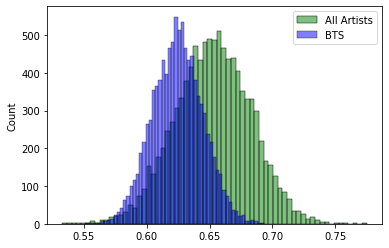

In [ ]:
bootstrap_plot("danceability")

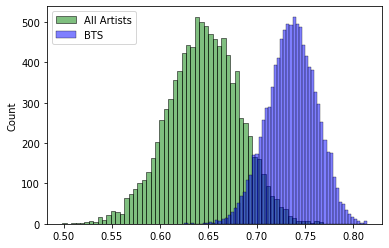

In [ ]:
bootstrap_plot("energy")

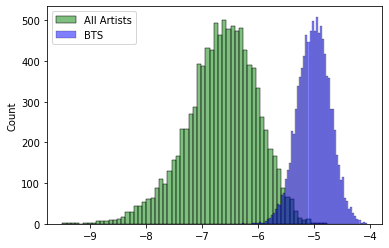

In [ ]:
bootstrap_plot("loudness")

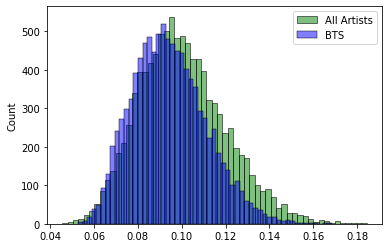

In [ ]:
bootstrap_plot("speechiness")

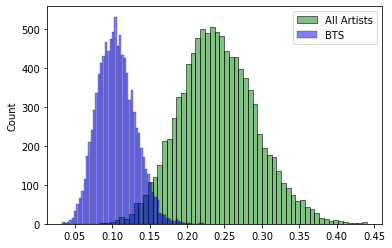

In [ ]:
bootstrap_plot("acousticness")

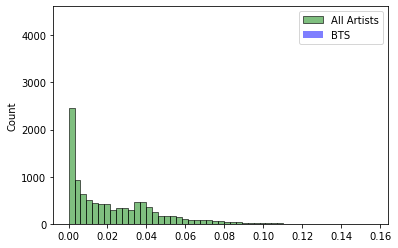

In [ ]:
bootstrap_plot("instrumentalness")

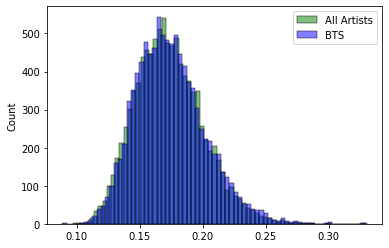

In [ ]:
bootstrap_plot("liveness")

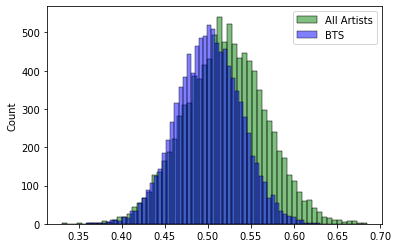

In [ ]:
bootstrap_plot("valence")

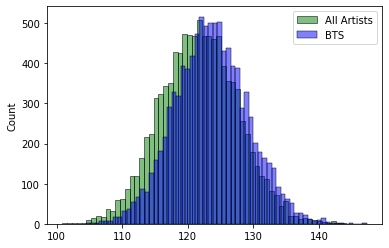

In [ ]:
bootstrap_plot("tempo")

In summary, BTS's tracks were on average: <br/><br/>
**Less Danceable**<br/>
**More Energy**<br/>
**More Loud**<br/>
Slightly Less Speechy<br/>
Slightly More Acoustic<br/>
Less Instrumental<br/>
Indistinguishably Live<br/>
**Slightly More Positive**<br/>
Slightly More Faster<br/>

Interestingly BTS is noticeably less danceable than the average popular track.

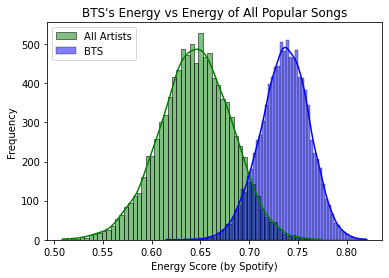

In [ ]:
sns.histplot(bootstrap(pop_tracks, "energy"), color = "green", alpha= 0.5, label = "All Artists", kde=True)
sns.histplot(bootstrap(pop_BTS_tracks, "energy"), color= "blue", alpha = 0.5, label= "BTS", kde=True)
plt.xlabel('Energy Score (by Spotify)')
plt.ylabel('Frequency')
plt.title("BTS's Energy vs Energy of All Popular Songs")
plt.legend()
plt.show()